# CTA observation simulation
L. Jouvin & F. Acero

WARNING : this is still a work in progress. So far you can get a CTA simulated event cube but counts in bkg seem too high (nee to check) and for now need to keep E-binning same as defined in CTA IRF as we can not interpolate the bkg cube on the desired E-binning.

This CTA simulation is based on Lea Jouvin's 3D analysis of HESS data.
The idea is to keep the same data structure as the HESS analysis: 

- use an hdu-index.fits.gz file and use several runs as different pointings
- in each run, replace the HESS irf by the CTA irf
- Build the exposure cube, PSF cube, bkg cube, and RMF cube (TODO)
- Then construct a spectro-spatial model with sherpa
- Compute the predicted count cube 
- Draw a random Poisson distribution from this cube
- TODO: Based on the predicted count cube, randomie events in X,Y, E pixels and draw an event list 

Most of the code below is adapted from Lea's notebooks :
[cube_analysis_part1](http://nbviewer.jupyter.org/github/gammapy/gammapy-extra/blob/master/notebooks/cube_analysis_part1.ipynb) & 
[cube_analysis_part2](http://nbviewer.jupyter.org/github/gammapy/gammapy-extra/blob/master/notebooks/cube_analysis_part2.ipynb)


Current status :
- Code starts from a HESS data structure (hdu-index, obs-index, irf-file) and uses DataStore
- Make mean RMF has not been implemented yet
- Code runs up to Npredicted count cube. However the Npred for bkg is very high (maybe a unit or reproject issue ?)
- mean_psf_cube is empty in the last two E-bins creating Nan in the Npred cube if Emax=199 TeV like in the CTA irf file. Using smaller Emax fixes the issue. Need to be able to reproject bkg_cube to different Ebin (see below).
- Bkg cube in CTA irf needs to be repojected on desired X,Y,E binning. The reproject module can reproject on X,Y but not in E binning. Need to find a way around that (in bkg_cube=ref_cube_cta_irf_bkg.reproject(ref_cube_images) )


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

#import sys
#sys.path.append("/Users/facero/Documents/Work/Program/gammapy/gammapy")

from ipywidgets.widgets.interaction import interact, fixed


import warnings; warnings.filterwarnings('ignore')

import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle

from gammapy.extern.pathlib import Path
from gammapy.data import DataStore, ObservationList
from gammapy.image import SkyMask
from gammapy.cube import SkyCube, StackedObsCubeMaker
from gammapy.utils.energy import Energy, EnergyBounds
from gammapy.irf import TablePSF
from gammapy.background import fill_acceptance_image


from gammapy.utils.nddata import NDDataArray
NDDataArray.default_interp_kwargs = dict(bounds_error=False, fill_value=None)


from gammapy.scripts import CTAIrf
from gammapy.cube import exposure_cube


from gammapy.cube.sherpa_ import (
    CombinedModel3DInt,
    CombinedModel3DIntConvolveEdisp,
    NormGauss2DInt,
)

from sherpa.models import PowLaw1D, TableModel
from sherpa.estmethods import Covariance
from sherpa.optmethods import NelderMead
from sherpa.stats import Cash
from sherpa.fit import Fit

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find xpaget on your PATH'


failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find xpaget on your PATH'


In [2]:
def make_empty_cube(image_size_x, image_size_y, energy, center, binsz=0.02, coordsys='GAL', data_unit=None):
    """
    Parameters
    ----------
    image_size:int, Total number of pixel of the 2D map in X and Y
    energy: Tuple for the energy axis: (Emin,Emax,nbins)
    center: SkyCoord of the source
    unit : str, Data unit.
    """
    def_image = dict()
    def_image["nxpix"] = image_size_x
    def_image["nypix"] = image_size_y
    def_image["binsz"] = binsz
    def_image["xref"] = center.galactic.l.deg
    def_image["yref"] = center.galactic.b.deg
    def_image["proj"] = 'TAN'
    def_image["coordsys"] = coordsys
    def_image["unit"] = data_unit
    e_min, e_max, nbins = energy
    empty_cube = SkyCube.empty(
        emin=e_min.value, emax=e_max.value, enumbins=nbins,
        eunit=e_min.unit, mode='edges', **def_image)
    return empty_cube


#Define a method for the mean psf from a list of observation
def make_mean_psf_cube(image_size, energy_cube, center_maps, center, ObsList,
                       spectral_index=2.3, binsz=0.02):
    """
    Compute the mean psf for a set of observation for different energy bands
    Parameters
    ----------
    image_size:int, Total number of pixel of the 2D map
    energy: Tuple for the energy axis: (Emin,Emax,nbins)
    center_maps: SkyCoord
            center of the images
    center: SkyCoord 
            position where we want to compute the psf
    ObsList: ObservationList to use to compute the psf (could be different that the data_store for G0p9 for the GC for example)
    spectral_index: assumed spectral index to compute the psf

    Returns
    -------
    ref_cube : `~gammapy.cube.SkyCube`
             PSF mean cube

    """
    ref_cube = make_empty_cube(image_size,image_size, energy_cube, center_maps, binsz)
    header = ref_cube.sky_image_ref.to_image_hdu().header
    energy_bins = ref_cube.energies(mode="edges")
    for i_E, E in enumerate(energy_bins[0:-1]):
        energy_band = Energy([energy_bins[i_E].value, energy_bins[i_E + 1].value], energy_bins.unit)
        energy = EnergyBounds.equal_log_spacing(energy_band[0].value, energy_band[1].value, 100, energy_band.unit)
        psf_energydependent = ObsList.make_psf(center, energy, theta=None)
        try:
            psf_table = psf_energydependent.table_psf_in_energy_band(energy_band, spectral_index=spectral_index)
        except:
            psf_table = TablePSF(psf_energydependent.offset,
                                 u.Quantity(np.zeros(len(psf_energydependent.offset)), u.sr ** -1))
        ref_cube.data[i_E, :, :] = fill_acceptance_image(header, center_maps, psf_table._offset.to("deg"),
                                                         psf_table._dp_domega, psf_table._offset.to("deg")[-1]).data
    return ref_cube



def plot_cube(cube,i):
    plt.imshow(cube[i,:,:],interpolation='nearest')
    plt.colorbar()
    
#    plt.title('E = %.1f - %.1f TeV' %(e[i].value,e[i+1].value))


In [3]:
# J. Lefaucheur script needed to read CTA irf bkg cube
cta_irf_file='../datasets/cta/cta-simu-data/irf/irf_file.fits'
cta_irf = CTAIrf.read(cta_irf_file)

dataset_directory = "../datasets/cta/cta-simu-data/"
data_store = DataStore.from_dir(dataset_directory)



In [9]:
#ereco = [Energy(0.5, "TeV"), Energy(50, "TeV"), 10]

ereco = [Energy(0.012589254,'TeV'), Energy(99.52623,'TeV'),21] # Use same energy as CTA IRF to avoid E interpolation for a start
#ereco = bkg_cube.energies(mode='edges')

etrue = ereco # Assuming no E dispersion in the beginning


center = SkyCoord(83.63, 22.01, unit='deg').galactic
xy_bins = 100 # number of X, Y pixels


# Cube to store the data, here ereco=etrue so this is the same for the counts, the bkg or the exposure
ref_cube_images = make_empty_cube(image_size_x=xy_bins, image_size_y=xy_bins, energy=ereco, center=center)
ref_cube_exposure = make_empty_cube(image_size_x=xy_bins, image_size_y=xy_bins ,energy=etrue, center=center, data_unit="m2 s")

In [10]:
obslist = [data_store.obs(id) for id in data_store.obs_table["OBS_ID"]]
ObsList = ObservationList(obslist)

pointing = ObsList[0].pointing_radec # pointing position
theta=center.separation(ObsList[0].pointing_radec) #offset of the source wrt to the pointing



mean_psf_cube = make_mean_psf_cube(image_size=xy_bins, energy_cube=etrue, center_maps=center, center=center,
                                   ObsList=ObsList,
                                   spectral_index=2.3)
filename_psf = 'psf_cube.fits'
mean_psf_cube.write(filename_psf, format="fermi-counts", clobber=True)


livetime = ObsList[0].observation_live_time_duration
exp_cube = exposure_cube(pointing,livetime,ObsList[0].aeff,ref_cube_exposure,offset_max=2.5*u.deg)



In [11]:
# Read bkg cube in CTA irf and dump it into an empty SkyCube object 

e_cube_cta_irf_bkg = [cta_irf.bkg.energy_edges[0],cta_irf.bkg.energy_edges[-1],cta_irf.bkg.energy_edges.nbins]

binsz = cta_irf.bkg.coord_wcs.wcs.cdelt[0] #assumed to be in degrees

image_size_x = cta_irf.bkg.coordx_edges.shape[0]-1
image_size_y = cta_irf.bkg.coordy_edges.shape[0]-1

ref_cube_cta_irf_bkg = make_empty_cube(image_size_x=image_size_x,image_size_y=image_size_y,
                                       binsz=binsz, energy=e_cube_cta_irf_bkg, center=pointing)

ref_cube_cta_irf_bkg.data[:] =   cta_irf.bkg.data*cta_irf.bkg.bin_volume*livetime

# TODO interpolate in energy in the cube. For test uses same E binning as CTA irf  
bkg_cube=ref_cube_cta_irf_bkg.reproject(ref_cube_images)



#interact(plot_,cube=fixed(cta_irf.bkg.data),i=(0,10))

# Part 2: Define Sherpa model 

In [12]:
counts_3d = SkyCube.empty_like(bkg_cube)

cube = counts_3d.to_sherpa_data3d(dstype='Data3DInt')

bkg = TableModel('bkg')
bkg.load(None, bkg_cube.data.value.ravel())
bkg.ampl = 1
bkg.ampl.freeze()

exposure_3d = exp_cube

exposure_3d.data = exp_cube.data.to('cm2 s')

i_nan = np.where(np.isnan(exposure_3d.data))
exposure_3d.data[i_nan] = 0



psf_3d = mean_psf_cube

In [15]:
# Define a 2D gaussian for the spatial model
spatial_model = NormGauss2DInt('spatial-model')

# Define a power law for the spectral model
spectral_model = PowLaw1D('spectral-model')

# Combine spectral and spatial model
coord = counts_3d.sky_image_ref.coordinates(mode="edges")
energies = counts_3d.energies(mode='edges').to("TeV")

# Here the source model will be convolve by the psf:
# PSF * (source_model * exposure)
source_model = CombinedModel3DInt(
    coord=coord,
    energies=energies,
    use_psf=True,
    exposure=exposure_3d,
    psf=psf_3d,
    spatial_model=spatial_model,
    spectral_model=spectral_model,
)


center = SkyCoord(83.633083, 22.0145, unit="deg").galactic
source_model.gamma = 2.2
source_model.xpos = center.l.value
source_model.ypos = center.b.value
source_model.fwhm = 0.12
source_model.ampl = 1.0


# Define the model
flux_factor = 1e-11

model = bkg + flux_factor * source_model
#model = flux_factor * source_model


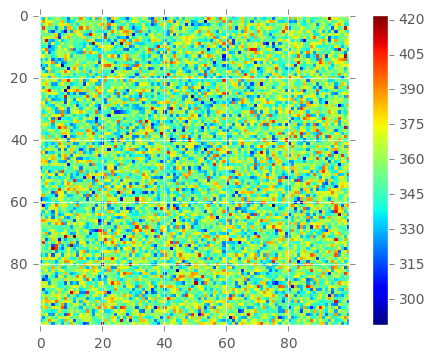

In [16]:
parameters = [_.val for _ in model.pars]
print(parameters)

len_ = counts_3d.data.ravel().shape[0]
lo = np.linspace(0.,1.,len_)
hi = lo

res=model.calc(parameters,lo,hi,lo,hi,lo,hi)

new_res=res.reshape(counts_3d.data.shape)
new_res[new_res < 0] = 0 # Avoid very small negative Npred values (~ -1e-15)


new_res_cts = np.random.poisson(new_res)

interact(plot_cube, cube=fixed(new_res_cts), i=(0,20,1))

## TEST ZONE

<function __main__.plot_>

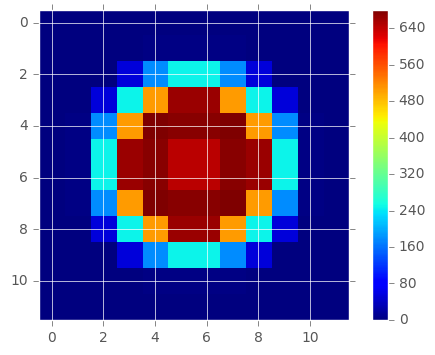

In [61]:
ref_cube_cta_irf_bkg.data[:] =   cta_irf.bkg.data*cta_irf.bkg.bin_volume*livetime

interact(plot_,cube=fixed(ref_cube_cta_irf_bkg.data),i=(0,10))


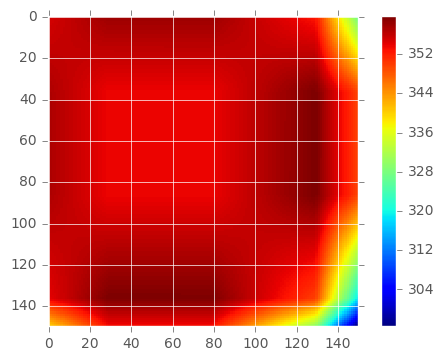

In [64]:
bkg_cube=ref_cube_cta_irf_bkg.reproject(ref_cube_images)
interact(plot_,cube=fixed(bkg_cube.data),i=(0,10,1) )

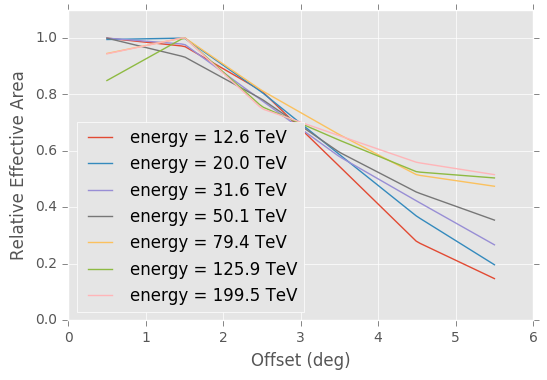

In [6]:
cta_irf.aeff.plot_offset_dependence(energy=cta_irf.aeff.energy.bins[15:])


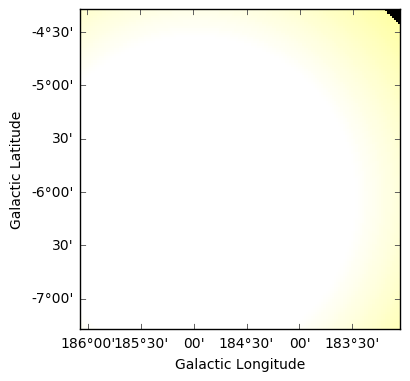

In [12]:
livetime = o.observation_live_time_duration
exp_cube = exposure_cube(pointing,livetime,ObsList[0].aeff,ref_cube_exposure,offset_max=2.5*u.deg)

exp_cube.show()

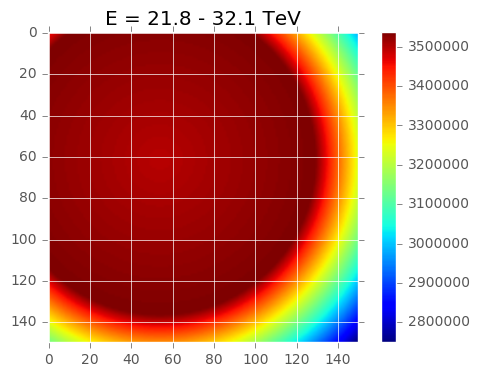

In [11]:
coordinates = ref_cube_exposure.sky_image_ref.coordinates()
offset = coordinates.separation(pointing)
aeff2d = ObsList[0].aeff

#e = EnergyBounds.equal_log_spacing(Energy(10.83798387, "TeV"), Energy(46.13404173, "TeV"), 10, "TeV")
e = EnergyBounds.equal_log_spacing(Energy(10, "TeV"), Energy(70, "TeV"), 5, "TeV")
#e=aeff2d.energy.nodes

#energy = ref_cube_exposure.energies()


exposure = aeff2d.data.evaluate(offset=offset,energy=e)


interact(plot_,cube=fixed(exposure),i=(0,10))

<function __main__.plot_>

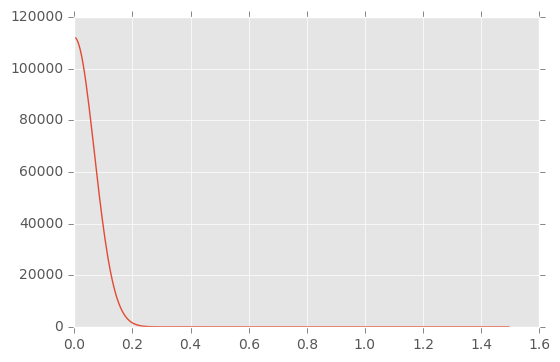

In [21]:
p=ob.psf.to_energy_dependent_table_psf(theta=theta)
rad=ob.psf.to_energy_dependent_table_psf(theta=theta).offset


def plot_(i):
    plt.plot(rad.to('deg'),p.psf_value[i])
interact(plot_,i=(0,10))    

## Make the cube analysis assuming a true energy different than the reconstructed energy

In [19]:
#Load data
data_store = DataStore.from_dir(dataset_directory)

#Define the Cubes in reco and true energies: the counts and bkg cube are in reco energy and the exposure in true energy
ereco = [Energy(0.5, "TeV"), Energy(40, "TeV"), 5]
etrue = [Energy(0.1, "TeV"), Energy(100, "TeV"), 20]
center = SkyCoord(83.63, 22.01, unit='deg').galactic

ref_cube_images = make_empty_cube(image_size=50, energy=ereco, center=center)
ref_cube_exposure = make_empty_cube(image_size=50, energy=etrue, center=center, data_unit="m2 s")

# Define the Exclusion Mask
refheader = ref_cube_images.sky_image_ref.to_image_hdu().header
exclusion_mask = SkyMask.read('$GAMMAPY_EXTRA/datasets/exclusion_masks/tevcat_exclusion.fits')
exclusion_mask = exclusion_mask.reproject(reference=refheader)

# Pb with the load psftable for one of the run that is not implemented yet...
data_store.hdu_table.remove_row(14)
cube_maker = StackedObsCubeMaker(empty_cube_images=ref_cube_images, empty_exposure_cube=ref_cube_exposure,
                                 offset_band=offset_band, data_store=data_store, obs_table=data_store.obs_table,
                                 exclusion_mask=exclusion_mask, save_bkg_scale=True)
cube_maker.make_cubes(make_background_image=True, radius=10.)
obslist = [data_store.obs(id) for id in data_store.obs_table["OBS_ID"]]
ObsList = ObservationList(obslist)

#The PSF cube is now calculated in true energie
mean_psf_cube = make_mean_psf_cube(image_size=50, energy_cube=etrue, center_maps=center, center=center,
                                   ObsList=ObsList,
                                   spectral_index=2.3)


filename_mask = 'exclusion_mask.fits'
filename_counts = 'counts_cube.fits'
filename_bkg = 'bkg_cube.fits'
filename_significance = 'significance_cube.fits'
filename_excess = 'excess_cube.fits'
filename_exposure = 'exposure_cube_etrue.fits'
filename_psf = 'psf_cube_etrue.fits'
exclusion_mask.write(filename_mask, clobber=True)
cube_maker.counts_cube.write(filename_counts, format="fermi-counts", clobber=True)
cube_maker.bkg_cube.write(filename_bkg, format="fermi-counts", clobber=True)
cube_maker.significance_cube.write(filename_significance, format="fermi-counts", clobber=True)
cube_maker.excess_cube.write(filename_excess, format="fermi-counts", clobber=True)
cube_maker.exposure_cube.write(filename_exposure, format="fermi-counts", clobber=True)
mean_psf_cube.write(filename_psf, format="fermi-counts", clobber=True)



In [20]:
counts_energies=cube_maker.counts_cube.energies(mode="edges")
print("the bin edges of the count cubes ", counts_energies)
print("")
true_energies=cube_maker.exposure_cube.energies(mode="edges")
print("the bin edges of the exposure cubes ", true_energies)
print("")

('the bin edges of the count cubes ', <Quantity [  0.5       ,  1.20112443,  2.88539981,  6.93144843,
            16.65106415, 40.        ] TeV>)

('the bin edges of the exposure cubes ', <Quantity [  1.00000000e-01,  1.41253754e-01,  1.99526231e-01,
             2.81838293e-01,  3.98107171e-01,  5.62341325e-01,
             7.94328235e-01,  1.12201845e+00,  1.58489319e+00,
             2.23872114e+00,  3.16227766e+00,  4.46683592e+00,
             6.30957344e+00,  8.91250938e+00,  1.25892541e+01,
             1.77827941e+01,  2.51188643e+01,  3.54813389e+01,
             5.01187234e+01,  7.07945784e+01,  1.00000000e+02] TeV>)



### Define a method to compute the mean rmf from a set of observation

In [21]:
def make_mean_rmf(energy_true, energy_reco, center, ObsList):
    """
    Compute the mean psf for a set of observation and a given energy band
    Parameters
    ----------
    energy_true: Tuple for the energy axis: (Emin,Emax,nbins)
         for the true energy array
    energy_reco: Tuple for the energy axis: (Emin,Emax,nbins)   
         for the reco energy array
    source_name: name of the source you want to compute the image
    center: SkyCoord of the source
    ObsList: ObservationList to use to compute the psf (could be different that the data_store for G0p9 for the GC for example)


    Returns
    -------
    rmf: `~gammapy.irf.EnergyDispersion`
        Stacked EDISP for a set of observation
    """

    # Here all the observations have a center at less than 2 degrees from the Crab so it will be ok to estimate the mean psf on the Crab source postion (the area is define for offset equal to 2 degrees...)
    emin_true, emax_true, nbin_true = energy_true
    emin_reco, emax_reco, nbin_reco = energy_reco
    energy_true_bins = EnergyBounds.equal_log_spacing(emin_true, emax_true, nbin_true, 'TeV')
    energy_reco_bins = EnergyBounds.equal_log_spacing(emin_reco, emax_reco, nbin_reco, 'TeV')
    rmf = ObsList.make_mean_edisp(position=center, e_true=energy_true_bins, e_reco=energy_reco_bins)
    return rmf



In [22]:
mean_rmf = make_mean_rmf(energy_true=etrue, energy_reco=ereco, center=center, ObsList=ObsList)
filename_rmf = 'rmf.fits'
mean_rmf.write(filename_rmf, clobber=True)


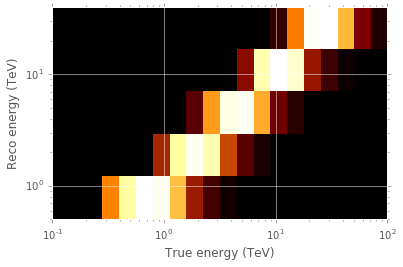

In [23]:
mean_rmf.plot_matrix()